# **Preparation**

In [1]:
# check gpu 
!nvidia-smi

Sun Dec  8 22:27:04 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# install kaggle package
!pip install -q kaggle

In [4]:
from google.colab import files
# upload needed data
uploaded = files.upload() 

Saving kaggle.json to kaggle.json


In [5]:
# use kaggle api to download the data
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!echo '{"username":"karentree","key":"ff57b9d030d708de9af1a8da9558d6df"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d karentree/artchanllage-genre-classification
# unzip the data
!unzip artchanllage-genre-classification.zip

 99% 2.34G/2.36G [00:27<00:00, 81.3MB/s]
100% 2.36G/2.36G [00:27<00:00, 93.4MB/s]
Archive:  artchanllage-genre-classification.zip
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_1.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_10.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_11.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_12.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_13.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_14.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_15.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_16.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_17.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_18.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_19.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expres

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.callbacks import *
from keras.initializers import *
from keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

Using TensorFlow backend.


# **Data Preparation**

In [0]:
# remove the broken data
os.remove('/content/genre/Northern_Renaissance/Northern_Renaissance_11.jpg')

In [8]:
# read csv
artists_unique = pd.read_csv("/content/artists_unique.csv")
artists_unique.head()

,Unnamed: 0,name,years,genre,nationality,paintings,number_of_genre,underscore
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,['Italian'],193,1,Amedeo_Modigliani
1,3,Claude Monet,1840 - 1926,Impressionism,['French'],73,1,Claude_Monet
2,5,Salvador Dali,1904 - 1989,Surrealism,['Spanish'],139,1,Salvador_Dali
3,7,Andrei Rublev,1360 - 1430,Byzantine_Art,['Russian'],99,1,Andrei_Rublev
4,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,['Dutch'],877,1,Vincent_van_Gogh


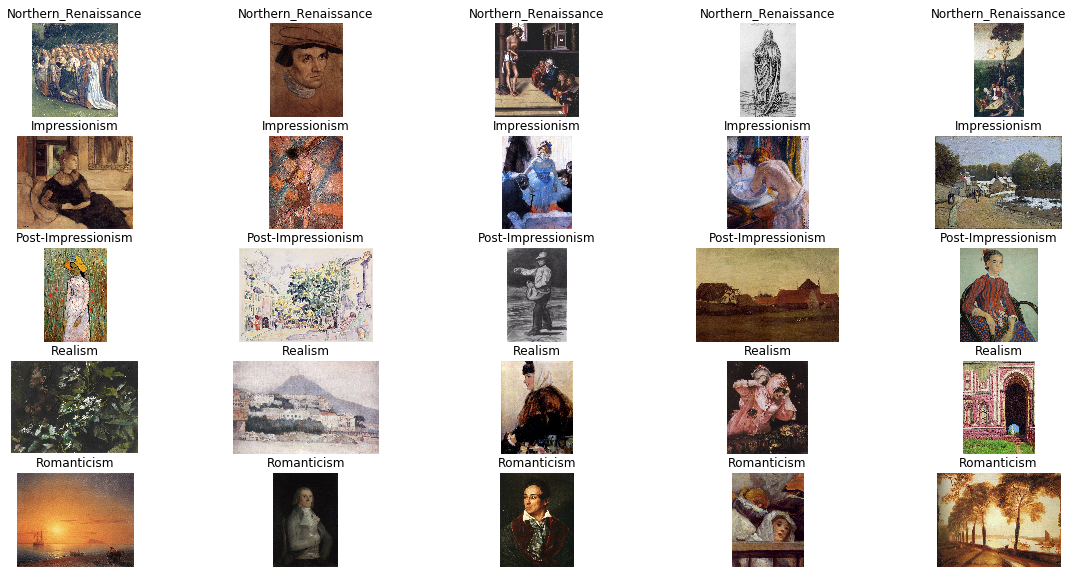

In [9]:
genre_series = artists_unique.groupby('genre')['paintings'].sum()
# put genre_series into dataframe
genre_df = pd.DataFrame(genre_series, columns=['paintings'])
genre_df['genre_weight'] = genre_df['paintings'].sum()/(genre_df.shape[0] * genre_df['paintings'])

# top five genres
genre_df['paintings'].sort_values(ascending=False)[:5]
genre_top5 = genre_df['paintings'].sort_values(ascending=False)[:5].index

n = 5
fig, axes = plt.subplots(5, n, figsize=(20,10))

genre_dir = '/content/genre/'
# draw random pictures from top 5 genres
for i, genre in enumerate(genre_top5):
  for j in range(n):
    random_image_file = random.choice(os.listdir(genre_dir+genre))
    #print(random_image_file)
    image = plt.imread(os.path.join(genre_dir,genre,random_image_file))
    axes[i][j].imshow(image)
    axes[i][j].axis('off')
    axes[i][j].set_title(genre)
plt.show()

# **Data Augmentation**

In [0]:
# initialize the Image data generator
aug = ImageDataGenerator(validation_split=0.2,
                         rescale=1./255.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True)

In [0]:
# only choose genres having more than 200 pictures
genre_series = genre_series[genre_series > 200]

In [12]:
batch_size = 12
train_input_shape = (224, 224, 3)

# use flow_from_directory method to generate train data
train_generator = aug.flow_from_directory(directory=genre_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=genre_series.index.to_list()
                                                   )
# use flow_from_directory method to generate test data
valid_generator = aug.flow_from_directory(directory=genre_dir,
                                               class_mode='categorical',
                                               target_size=train_input_shape[0:2],
                                               batch_size=batch_size,
                                               subset="validation",
                                               shuffle=True,
                                               classes=genre_series.index.to_list())
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 9801 images belonging to 15 classes.
Found 2443 images belonging to 15 classes.
Total number of batches = 816 and 203


# **Model Built**

In [13]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [14]:
# get class size
n_classes=genre_series.shape[0]

# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.7)(X)
X = Activation('relu')(X)
X = BatchNormalization()(X)


X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.7)(X)
X = Activation('relu')(X)
X = BatchNormalization()(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [15]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [17]:
class_weights = genre_series.sum()/(len(genre_series) * genre_series)
class_weights

genre
Art_Nouveau             1.797210
Baroque                 1.062413
Cubism                  1.858618
Early_Renaissance       2.833102
Expressionism           1.480823
High_Renaissance        2.435622
Impressionism           0.512843
Northern_Renaissance    0.483087
Post-Impressionism      0.519703
Primitivism             2.640561
Realism                 0.552052
Romanticism             0.613023
Socialist_Realism       1.854394
Surrealism              3.385615
Symbolism               1.080706
Name: paintings, dtype: float64

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [19]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger("Resnet_history_genre_200_log.csv", append=True)

history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, csv_logger],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
816/816 [==============================] - 314s 385ms/step - loss: 1.9375 - acc: 0.4325 - val_loss: 1.8539 - val_acc: 0.4520
Epoch 2/30
816/816 [==============================] - 297s 364ms/step - loss: 1.4550 - acc: 0.5954 - val_loss: 1.6769 - val_acc: 0.4949
Epoch 3/30
816/816 [==============================] - 296s 363ms/step - loss: 1.3122 - acc: 0.6333 - val_loss: 1.5833 - val_acc: 0.5401
Epoch 4/30
816/816 [==============================] - 295s 361ms/step - loss: 1.1687 - acc: 0.6742 - val_loss: 1.7223 - val_acc: 0.4944
Epoch 5/30
816/816 [==============================] - 300s 368ms/step - loss: 1.0268 - acc: 0.7132 - val_loss: 1.5147 - val_acc: 0.5434
Epoch 6/30
816/816 [==============================] - 300s 367ms/step - loss: 0.9486 - acc: 0.7328 - val_loss: 1.4924 - val_acc: 0.5627
Epoch 7/30
816/816 [==============================] - 306s 375ms/step - loss: 0.8517 - a

In [20]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 10

csv_logger_avg = CSVLogger("Resnet_history_genre_avg_log.csv", append=True)
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop,csv_logger_avg],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/10
816/816 [==============================] - 305s 374ms/step - loss: 0.0929 - acc: 0.9794 - val_loss: 1.1260 - val_acc: 0.6958
Epoch 2/10
816/816 [==============================] - 294s 360ms/step - loss: 0.1009 - acc: 0.9773 - val_loss: 1.1675 - val_acc: 0.6754
Epoch 3/10
816/816 [==============================] - 294s 360ms/step - loss: 0.0999 - acc: 0.9765 - val_loss: 1.2389 - val_acc: 0.6689
Epoch 4/10
816/816 [==============================] - 296s 362ms/step - loss: 0.1012 - acc: 0.9780 - val_loss: 1.1617 - val_acc: 0.6841
Epoch 5/10
816/816 [==============================] - 298s 365ms/step - loss: 0.0975 - acc: 0.9789 - val_loss: 1.1524 - val_acc: 0.6734
Epoch 6/10
816/816 [==============================] - 298s 366ms/step - loss: 0.1017 - acc: 0.9763 - val_loss: 1.2490 - val_acc: 0.6578

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 7/10
816/816 [==============================] - 296s 363ms/step - loss: 0.0950 - acc: 0.9778 - va

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


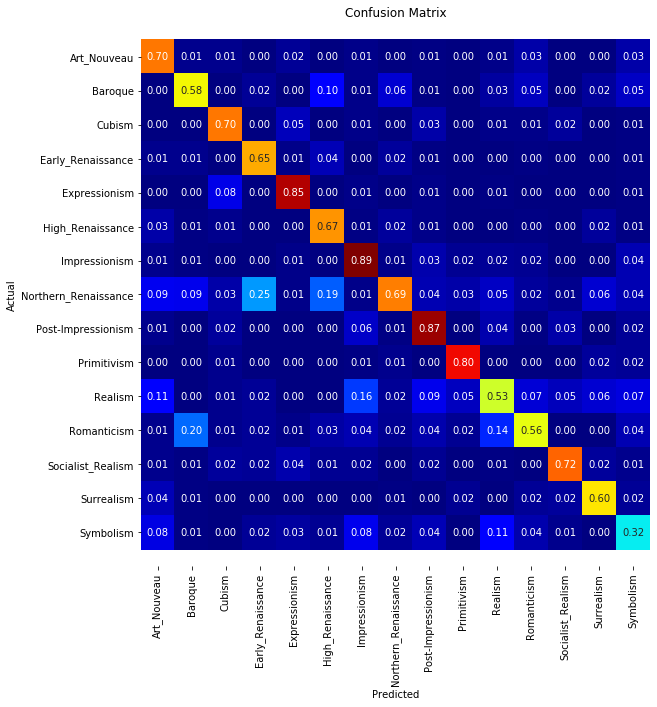

Classification Report:
                      precision    recall  f1-score   support

         Art_Nouveau       0.63      0.70      0.66        90
             Baroque       0.62      0.58      0.60       152
              Cubism       0.76      0.70      0.73        87
   Early_Renaissance       0.66      0.65      0.65        57
       Expressionism       0.84      0.85      0.85       110
    High_Renaissance       0.62      0.67      0.65        67
       Impressionism       0.68      0.89      0.77       318
Northern_Renaissance       0.78      0.69      0.73       331
  Post-Impressionism       0.72      0.87      0.79       315
         Primitivism       0.86      0.80      0.83        61
             Realism       0.55      0.53      0.54       292
         Romanticism       0.68      0.56      0.62       266
   Socialist_Realism       0.83      0.72      0.77        88
          Surrealism       0.74      0.60      0.66        47
           Symbolism       0.46      0.32     

In [25]:
from keras.models import load_model

path = "/content/gdrive/My Drive/Resnet_model_genre_200.h5" 
model.save(path)

# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = genre_series.index.to_list()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=tick_labels))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)


Text(0, 0.5, 'accuracy')

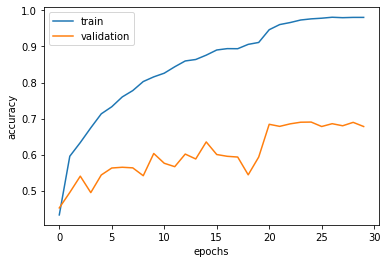

In [26]:
# copy log csv to google drive
!cp /content/Resnet_history_genre_200_log.csv /content/gdrive/My\ Drive/

import matplotlib.pyplot as plt

plt.plot(history1.history['acc'], label='train')
plt.plot(history1.history['val_acc'], label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
